This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [2]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [3]:
control_name = '7a_v6699_1000kg_360d_highres_daily_control'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [4]:
time = np.ma.filled(control.variables['t'], np.nan)

In [5]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('7a_v6699_1000kg_360d_highres_daily/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
scenario_paths

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/7a_v6699_1000kg_360d_highres_daily/outputSalishSea.nc')]

In [6]:
duration_ns = time - time[0]
duration = duration_ns.astype('timedelta64[D]')
duration[1]

numpy.timedelta64(1,'D')

In [7]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

In [8]:
def compare_scenario_pah(species, pah, boxes=groups.salish_sea):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        contam_tbl = np.ma.filled(scenario.variables[species+'_' + pah][:,boxes,:], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,boxes,:], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(duration, contam_mass_t/1e6)
    ax.legend(names)
    ax.set_ylabel(species + ' PAH (kg)')
    ax.set_title(pah, fontsize = 12);

In [9]:
def print_max_pah_conc(species, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[species +'_'+ pah], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            max_contam_mass = contam_t.max()/1e6
            print(path.parent.stem, species, pah, max_contam_mass)

In [37]:
def group_mass(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            volume_tbl = np.ma.filled(scenario.volume, np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            ax.plot(time, contam_mass_t/1e6) 
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_mass_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('mass (Kg)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [33]:
def group_conc(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^3$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [31]:
def group_conc_benthic(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tb = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_t = contam_tb.sum(axis=1)
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_t, delimiter = ",")
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^2$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

### Water Column - without resets

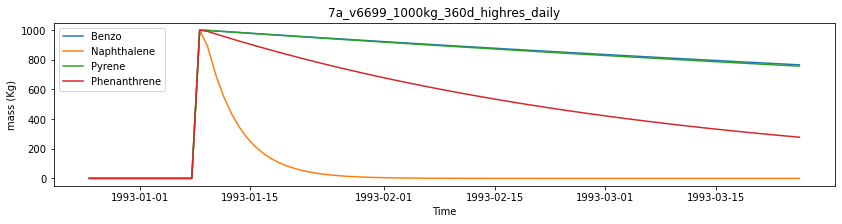

In [38]:
group_mass(groups.pahs, scenario_datasets, scenario_paths)


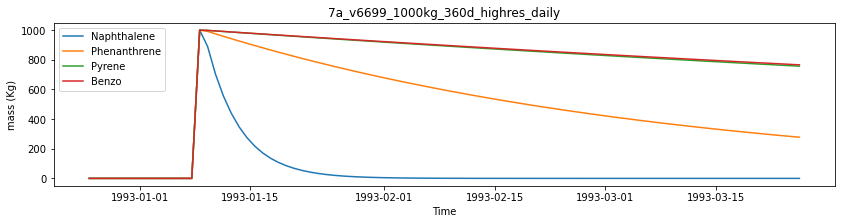

In [13]:
splot.group_mass(groups.pahs, scenario_datasets, scenario_paths)

In [14]:
for scenario in scenario_datasets:
    contam_t = np.ma.filled(scenario.variables['Naphthalene'][:,1,5], np.nan)

In [15]:
num = 13
print('Concentration (mg/m3) of contaminants released in Box 1 on '+str(time[num])+' is '+str(contam_t[num]))

Concentration (mg/m3) of contaminants released in Box 1 on 1993-01-07T14:00:00.000000000 is 0.0


In [16]:
num = 14
print('Concentration (mg/m3) of contaminants released in Box 1 on '+str(time[num])+' is '+str(contam_t[num]))

Concentration (mg/m3) of contaminants released in Box 1 on 1993-01-08T14:00:00.000000000 is 0.060263202450966


### Biology

Uptake rates for contaminants in phytoplankton
- PL_Naphthalene_uptake_rate    = 3.0e-3
- PL_Phenanthrene_uptake_rate   = 2.0e-4
- PL_Pyrene_uptake_rate         = 1.4e-4
- PL_Benzo_uptake_rate          = 8.0e-5

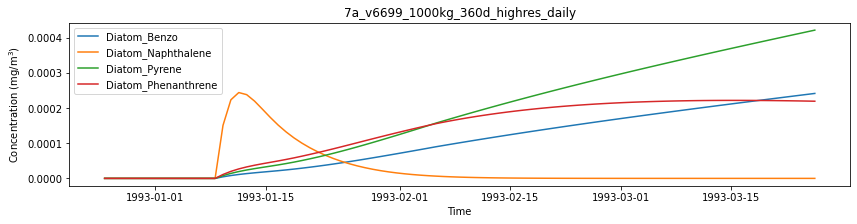

In [34]:
new_group = {}
for pah in groups.pahs:
    new_group['Diatom_'+pah]= 'Diatom_' +pah
group_conc(new_group, scenario_datasets, scenario_paths)

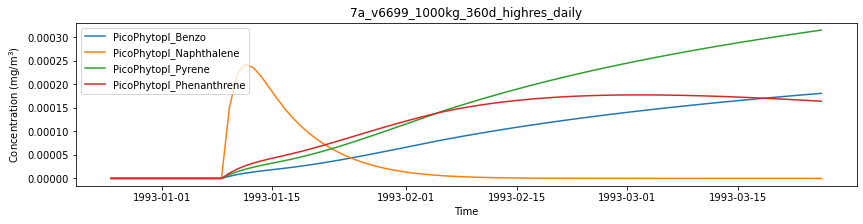

In [35]:
new_group = {}
for pah in groups.pahs:
    new_group['PicoPhytopl_'+pah]= 'PicoPhytopl_' +pah
group_conc(new_group, scenario_datasets, scenario_paths)

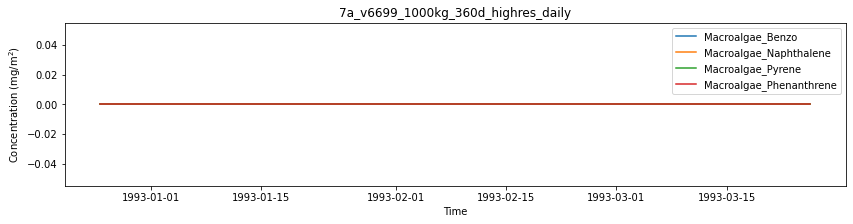

In [32]:
new_group = {}
for pah in groups.pahs:
    new_group['Macroalgae_'+pah]= 'Macroalgae_' +pah
group_conc_benthic(new_group, scenario_datasets, scenario_paths)

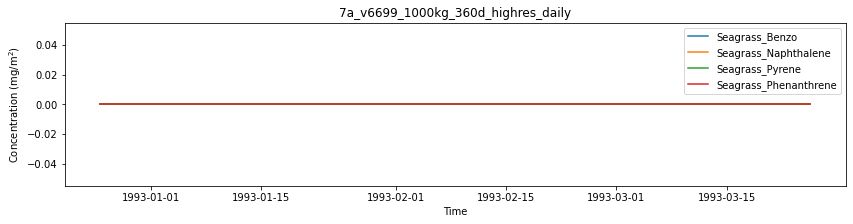

In [39]:
new_group = {}
for pah in groups.pahs:
    new_group['Seagrass_'+pah]= 'Seagrass_' +pah
group_conc_benthic(new_group, scenario_datasets, scenario_paths)

In [20]:
print_max_pah_conc('Ref_Det', scenario_datasets, scenario_paths)

7a_v6699_1000kg_360d_highres_daily Ref_Det Naphthalene 8.46445120110344e-12
7a_v6699_1000kg_360d_highres_daily Ref_Det Phenanthrene 1.529017832332607e-08
7a_v6699_1000kg_360d_highres_daily Ref_Det Pyrene 1.9368717482872063e-07
7a_v6699_1000kg_360d_highres_daily Ref_Det Benzo 1.1038229811213837e-07


In [1]:
max_Ref_Det_Pyr_percent = (1.9368717482872063e-07/0.060263202450966)*100
max_Ref_Det_Pyr_percent

0.0003214020612102666

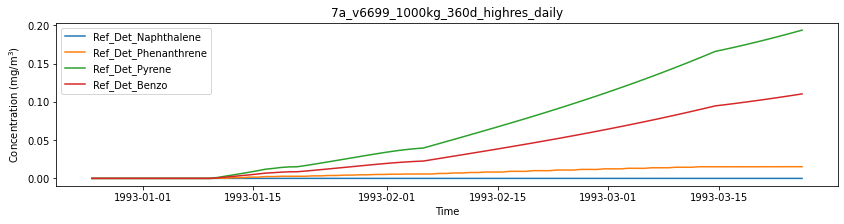

In [22]:
new_group = {}
for pah in groups.pahs:
    new_group['Ref_Det_'+pah]= 'Ref_Det_' +pah
splot.group_conc(new_group, scenario_datasets, scenario_paths)

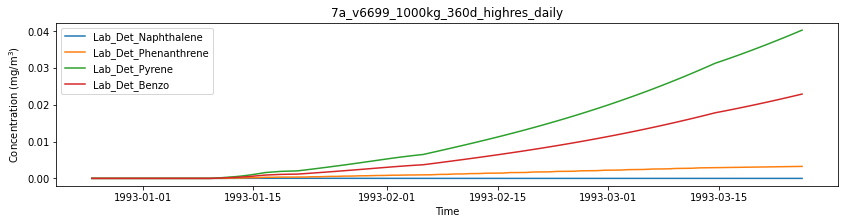

In [23]:
new_group = {}
for pah in groups.pahs:
    new_group['Lab_Det_'+pah]= 'Lab_Det_' +pah
splot.group_conc(new_group, scenario_datasets, scenario_paths)

### vertebrate contaminants

Hake (FHK) - example vertebrate with faster spawn/recruitment time
- Time of year Hake spawn (FHK_Time_Spawn): Day 70
- Length of larval period for Hake: (FHK_Recruit_Time) = 20 days
- FHK_Naphthalene_uptake_rate 1.0e-09

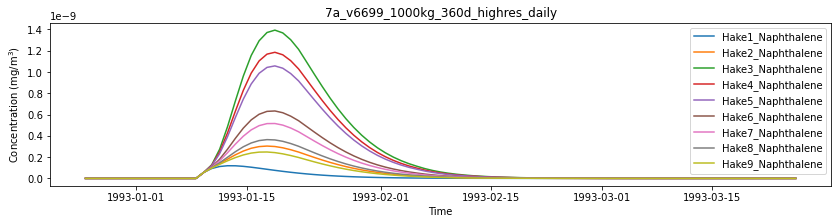

In [24]:
new_group = {}
for cohort in range (1, groups.cohorts['Hake']):
    new_group['Hake'+str(cohort)+'_Naphthalene']= 'Hake'+str(cohort)+'_Naphthalene'
splot.group_conc(new_group, scenario_datasets, scenario_paths)

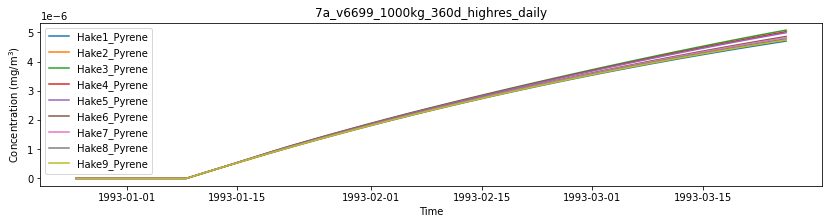

In [25]:
new_group = {}
for cohort in range (1, groups.cohorts['Hake']):
    new_group['Hake'+str(cohort)+'_Pyrene']= 'Hake'+str(cohort)+'_Pyrene'
splot.group_conc(new_group, scenario_datasets, scenario_paths)

No difference in concentrations over time for the different cohorts of Hake

Harbour Seals (HSK) - example vertebrate with longer spawn/gestation time
- Time of year Harbour Seals (HSL_Time_Spawn): Day 290
- Length of gestation period for Harbour seals (HSL_Recruit_Time) = 330 days
- HSL_Naphthalene_uptake_rate 1.0e-09

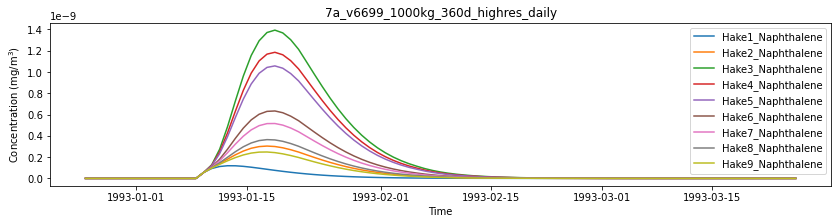

In [26]:
new_group = {}
for cohort in range (1, groups.cohorts['Harbor_seals']):
    new_group['Hake'+str(cohort)+'_Naphthalene']= 'Hake'+str(cohort)+'_Naphthalene'
splot.group_conc(new_group, scenario_datasets, scenario_paths)

In [ ]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.plankton, scenario, control, time, 0, 80, groups.salish_sea, time[14])

In [ ]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.pelagic_invertebrates, scenario, control, time, 0, 80, groups.salish_sea, time[14])

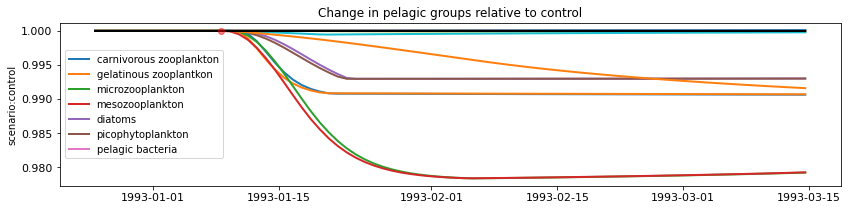

In [ ]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.mammals, scenario, control, time, 0, 80, groups.salish_sea, time[14])